In [1]:
from typing import Annotated, Literal
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages
from langchain.chat_models import init_chat_model
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from langchain_ollama import ChatOllama
import json

llm = ChatOllama(model="mistral:7b")

class Message_Classifier(BaseModel):
    message_type:Literal['emotional','logical'] = Field(
        ...,
        description="Classify if the message requires an emotional (therapist) or logical response.",
    )

class State(TypedDict):
    messages: Annotated[list, add_messages]
    message_type: str | None



def classify_message(state: State):
    last_message = state['messages'][-1]
    
    # Use a simple prompt-based classification since structured output isn't available
    classification_prompt = f"""
    Classify the following message as either 'emotional' or 'logical':
    - 'emotional': if it asks for emotional support, therapy, deals with feelings, or personal problems
    - 'logical': if it asks for facts, information, logical analysis, or practical solutions
    
    Message: "{last_message['content'] if isinstance(last_message, dict) else last_message.content}"
    
    Respond with only one word: either 'emotional' or 'logical'
    """
    
    result = llm.invoke(classification_prompt)
    message_type = result.content.strip().lower()
    
    # Ensure we get a valid classification
    if message_type not in ['emotional', 'logical']:
        message_type = 'logical'  # default fallback
    
    return {
        "message_type": message_type
    }

def router(state: State):
    message_type = state.get('message_type',"logical")
    if message_type == 'emotional':
        return{"next": "therapist" }
    else:
        return{"next": "logical" }

def therapist_agent(state: State):
    last_message = state['messages'][-1]
    user_content = last_message['content'] if isinstance(last_message, dict) else last_message.content
    
    messages = [
        {
            "role": "system",
             "content": """You are a compassionate therapist. Focus on the emotional aspects of the user's message.
                        Show empathy, validate their feelings, and help them process their emotions.
                        Ask thoughtful questions to help them explore their feelings more deeply.
                        Avoid giving logical solutions unless explicitly asked."""
        } ,
        {
            "role": "user",
            "content": user_content
        }
    ]
    reply = llm.invoke(messages)
    return {"messages": [{"role": "assistant", "content": reply.content}]}

def logical_agent(state: State):
    last_message = state["messages"][-1]
    user_content = last_message['content'] if isinstance(last_message, dict) else last_message.content

    messages = [
        {"role": "system",
         "content": """You are a purely logical assistant. Focus only on facts and information.
            Provide clear, concise answers based on logic and evidence.
            Do not address emotions or provide emotional support.
            Be direct and straightforward in your responses."""
         },
        {
            "role": "user",
            "content": user_content
        }
    ]
    reply = llm.invoke(messages)
    return {"messages": [{"role": "assistant", "content": reply.content}]}
graph_builder = StateGraph(State)

graph_builder.add_node("classifier",classify_message)
graph_builder.add_node("router", router)
graph_builder.add_node("therapist", therapist_agent)
graph_builder.add_node("logical", logical_agent)

graph_builder.add_edge(START, "classifier")
graph_builder.add_edge("classifier", "router") 
graph_builder.add_conditional_edges(
    "router",
    lambda state: state.get("next"),
    {
        "therapist": "therapist",
        "logical": "logical"
    }
)

graph_builder.add_edge("therapist", END)
graph_builder.add_edge("logical", END)

graph  = graph_builder.compile()

def run_chatbot():
    state = {
        "messages": [],
        "message_type": None
    }
    while True:
        user_input = input("You: ")
        if user_input.lower() in ["exit", "quit"]:
            print("Exiting chatbot.")
            break
        
        state["messages"] = state.get("messages", []) + [{
            "role": "user", "content": user_input
        }]

        state = graph.invoke(state)

        if state.get("messages") and len(state["messages"]) > 0:
            last_message = state["messages"][-1]
            if isinstance(last_message, dict):
                print(f"Bot: {last_message['content']}")
            else:
                print(f"Bot: {last_message.content}")

if __name__ == "__main__":
    run_chatbot()

ConnectError: [WinError 10061] No connection could be made because the target machine actively refused it

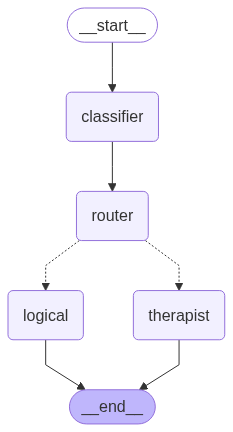

In [2]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    print(Exception)
    pass